## Детектирование объекта на изображении с использованием OpenCV

### Алгоритм:
- Шаг 1: Выделение границ применением оператора Собеля  
- Шаг 2: Удаление шума на полученном изображении  
- Шаг 3: Определение контуров предметов, выбор наиболее значимых
- Шаг 4: Удаление границ, которые входят в прямоугольник

In [1]:
from os.path import join
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

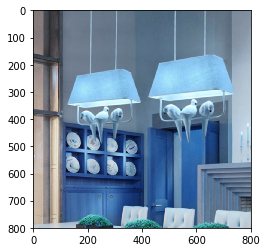

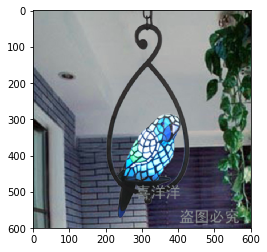

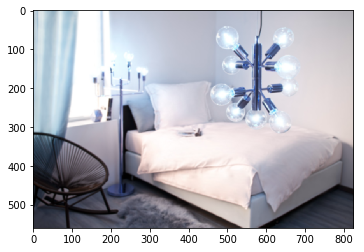

In [2]:
imgs = [ cv2.imread(join("images", img)) for img in ["ex1.jpg", "ex4.jpg", "ex5.jpg"] ]
blurred = [ cv2.GaussianBlur(img, (5, 5), 0) for img in imgs ]

# Считываем изоражение и удаляем шум
for img in blurred:
    plt.imshow(img)
    plt.show()

### Шаг 1: Выделение границ применением оператора Собеля

In [3]:
def edge_detect (channel):
    """
    Вспомогательная функция для определения границ
    
    @param channel: одна цветовая компонента изображения
    @return sobel: результат применения к ней операторов Собеля по x и y 
    
    """
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0, cv2.BORDER_CONSTANT)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1, cv2.BORDER_CONSTANT)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel

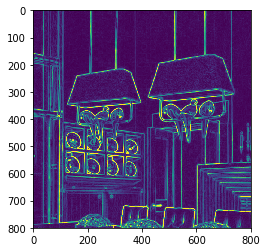

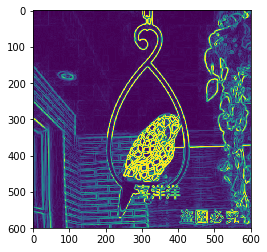

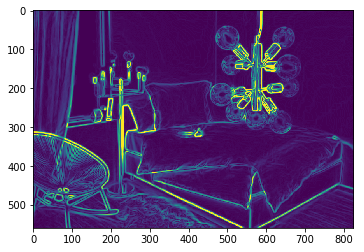

In [4]:
edge_imgs = []

for img in blurred:
    edge_img = np.max(np.array([
            edge_detect(img[:, :, 0]), 
            edge_detect(img[:, :, 1]), 
            edge_detect(img[:, :, 2])]), 
        axis=0)
    edge_imgs.append(edge_img)

    plt.imshow(edge_img)
    plt.show()

### Шаг 2: Удаление шума

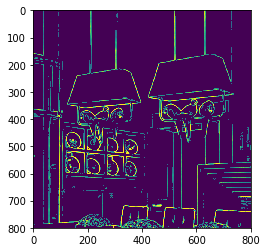

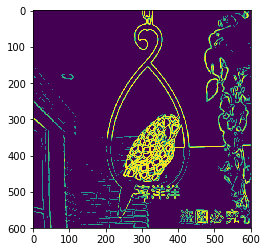

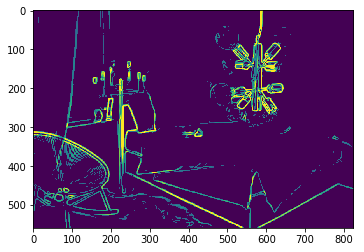

In [5]:
# Параметр shift влияет на качество работы (размер области)
for edge_img in edge_imgs:
    shift = np.std(edge_img)
    mean_img = np.mean(edge_img) + shift
    edge_img[edge_img <= mean_img] = 0

    plt.imshow(edge_img)
    plt.show()

### Шаг 3: Определение контуров предметов, выбор наиболее значимых

In [6]:
def find_significant_contours(img, edge_img):
    """
    Вспомогательная функция для нахождения главных контуров на изображении
    
    @param img: исходное изображение
    @param edge_img: изображение с выделенными границами
    @return sirted_conoutrs: главные контуры (list of np.array())
    
    """
    
    image, contours, heirarchy = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)

    significant = []
    too_small = edge_img.size * 3 / 100
    
    # Если контур не покрывает 3% всего изоражения, то не будем его учитывать
    for tupl in level1:
        contour = contours[tupl[0]];
        area = cv2.contourArea(contour)
        if area > too_small:
            significant.append([contour, area])

            # Избразим контуры на исходном изображении
            cv2.drawContours(img, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)

    significant.sort(key=lambda x: x[1])
    sorted_contours = [x[0] for x in significant]

    return sorted_contours[0]

### Шаг 4: Удаление границ, которые входят в прямоугольник

In [7]:
def crop(img, contour):
    """
    Выделение прямоугольника по контуру и обрезание изображения
    
    @param img: исходное изображение
    @param contour: целевой контур
    
    """
    x, y, w, h = cv2.boundingRect(contour)
    return img[y:y + h, x:x + w]

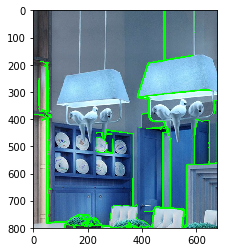

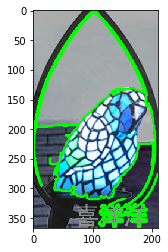

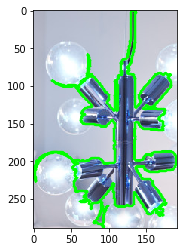

In [8]:
crop_imgs = []
alpha = 10

for i, edge_img in enumerate(edge_imgs):
    img = imgs[i]
    
    edge_img_8u = np.asarray(edge_img, np.uint8)
    significant = find_significant_contours(img, edge_img_8u)
    
    crop_img = crop(img, significant)
    crop_imgs.append(crop_img)

    plt.imshow(crop_img)
    plt.show()